# Tutorial: Investigation of Sparse Principal Component Analysis for image pre-processing

## Mathematical formulation

Let $\boldsymbol{X}$ be an $n \times p$ data matrix, where $n$ is the number of samples and $p$ is the number of features. In our cats and dogs example, the $p$ corresponds to the dimension of the flattened matrices of pixels (we consider only one channel for simplicity, so that we do not have to work with tensors).

First, we consider the first sparse principal component estimates only, $\hat{v}_1$. But as we will see, the algorithm can be generalized to the first $k$ SPC's. The optimization criterion we consider is the following.

\begin{equation}
(\hat{u}_1,\hat{v}_1)	=\underset{\tilde{u} \in \mathbb{R}^{n }, \tilde{v}\in \mathbb{R}^p}{{argmin}} \quad  \| \boldsymbol{X}-\tilde{u} \tilde{v}^T \|_F^2 + \sum_{j=1}^{p} 2\lambda|\tilde{v}_j|
\end{equation}

It is fairly easy to derive an algorithm from this criterion. For more details, see [this paper](http://www.sciencedirect.com/science/article/pii/S0047259X07000887) by Shen and Huang. We show here the pseudo-code of the algorithm. $h_\lambda$ is some thresholding operator (soft thresholding operator for example)

<img src="spc.png">

## Python implementation

### Data preparation

First, download the [data set](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition) and put the images in a directory "catdog/train/". The dataset is publicly available, but you may have to create a (free) Kaggle account if you don't have one already.

In [1]:
import time
import pywt
import os, cv2, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


We load the data into square grayscale images format, then convert each image to a flattened numpy array. Each sample has the same size.

In [2]:
IMG_PATH = 'catdog/train/'

ROWS = 64
COLS = 64
CHANNELS = 1

train_dogs =   [IMG_PATH+i for i in os.listdir(IMG_PATH) if 'dog' in i]
train_cats =   [IMG_PATH+i for i in os.listdir(IMG_PATH) if 'cat' in i]


In [3]:
#read a .jpg image
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) 
    return cv2.resize(img, (ROWS, COLS), interpolation = cv2.INTER_CUBIC)


In [4]:
#this method just load the data into numpy nd arrays

def prep_data(images):
    
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS * COLS), dtype = np.uint8)
    cnt_error = 0
    
    for i, image_file in enumerate(images):
        
        try:
            
            image = read_image(image_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            data[i] = image.flatten()
            
            
        except Exception as e: 
            
            print ('An exception occurred, value: {}'.format( str(e)))
            data[i] = data[i-1]
            cnt_error += 1
        
        
        
        if i%1000 == 0: print('Processed {} of {}'.format(i, count))
    print("{} errors".format(cnt_error))
    return data

### Implementation of the algorithm

In [5]:
class SPC(object):
    def __init__(self, number_of_components,max_iter=10, threshold_val=1.5 ):
        
        
        """Initialize the SPC object
        
        Positional arguments:
        number_of_components -- the number of sparse principal components 
        to compute, must be between 1 and p (total number of features)
        
        Keyword argument:
        max_iter -- the number of iterations to perform (default=10)
        threshold_val -- value of the lambda regularisation 
        parameter (default=10)
        """
        self.number_of_components=number_of_components
        self.max_iter=max_iter
        self.threshold_val=threshold_val
    
    def fit(self, X_):
        """learn the sparse pc of a data matrix, return sparse estimates
        of the left and right singular vectors (U and V respectively) 
        as well as the standard principal components loading matrix W
    
        Positional arguments:
        X_ -- training data matrix, as numpy ndarray
        
        """ 
        print("computing sparse principal components...")
        print("computing SVD of data matrix...")
        U, s, V = np.linalg.svd(X_, full_matrices=True)  
        cnt = 0
        self.U = U
        self.W=V.T
        def normalize(vector):
            norm=np.linalg.norm(vector)
            if norm>0:
                return vector/norm
            else:
                return vector
        print("starting iterations...")
        while True:
           
            self.V = pywt.threshold(np.dot(U[:self.number_of_components],X_), self.threshold_val)
            self.U = np.dot(self.V,X_.T)
            self.U = np.array([normalize(u_i) for u_i in self.U])
            if cnt%2==0:
                print("{} out of {} iterations".format(cnt,self.max_iter))
            cnt += 1
            if cnt == self.max_iter:
                self.V = np.array([normalize(v_i) for v_i in self.V])
                break
        print("...finish")
        return self.U, self.V, self.W

### Pre-processing

We flatten the images so that we can feed them to the algorithm.

In [6]:
train_dogs = prep_data(train_dogs).reshape((len(train_dogs), ROWS * COLS))
train_cats = prep_data(train_cats).reshape((len(train_cats), ROWS * COLS))

Processed 0 of 12500
Processed 1000 of 12500
Processed 2000 of 12500
Processed 3000 of 12500
Processed 4000 of 12500
Processed 5000 of 12500
Processed 6000 of 12500
Processed 7000 of 12500
Processed 8000 of 12500
Processed 9000 of 12500
Processed 10000 of 12500
Processed 11000 of 12500
Processed 12000 of 12500
0 errors
Processed 0 of 12500
Processed 1000 of 12500
Processed 2000 of 12500
Processed 3000 of 12500
Processed 4000 of 12500
Processed 5000 of 12500
Processed 6000 of 12500
Processed 7000 of 12500
Processed 8000 of 12500
Processed 9000 of 12500
Processed 10000 of 12500
Processed 11000 of 12500
Processed 12000 of 12500
0 errors


### Computation of SPC

In [7]:
# we keep the same number of components as input size
k=ROWS**2
# input is normalised, this is necessary to compute the sparse eigenvectors
df = pd.DataFrame(data = train_cats)
df_norm = (df - df.mean()) / (df.std())
X = df_norm.values
# 10 iterations seems to generate decent results. this parameter should theoretically be high
max_iter = 10
#the threshold value can be tuned to generate more or less sparsity, the higher the more sparse
threshold_val = 2.75
spc = SPC(k, max_iter = max_iter, threshold_val = threshold_val)
print("number of iterations: {}, threshold value: {}".format
          (max_iter,threshold_val))
#computation of the sparse eigenvectors
U, V, W = spc.fit(X)

# reconstruction of the images
X_reduced_spca = np.dot(X, np.dot(V[:k].T, V[:k]))


    

number of iterations: 10, threshold value: 2.75
computing sparse principal components...
computing SVD of data matrix...
starting iterations...
0 out of 10 iterations
2 out of 10 iterations
4 out of 10 iterations
6 out of 10 iterations
8 out of 10 iterations
...finish


In [8]:
#simple method to plot the results
def plot_fig(index):
    for ind in index:
        im_orig = train_cats[ind].copy()
        im = X_reduced_spca[ind].copy()
        im_neg = X_reduced_spca[ind].copy()

        
        print("image index: {}".format(str(ind)))
        plt.figure(figsize=(10, 10))
        plt.subplot(131)
        plt.subplot(131).set_title("Original image")
        plt.imshow(im_orig.reshape((ROWS, COLS)))
        
        im[im<0]=0
        plt.subplot(132)
        plt.subplot(132).set_title("spca positive pixels")
        plt.imshow(im.reshape((ROWS, COLS)))
        
        im_neg[im_neg>0]=0
        plt.subplot(133)
        plt.subplot(133).set_title("spca negative pixels")
        plt.imshow(im_neg.reshape((ROWS, COLS)))

        plt.show()

image index: 6159


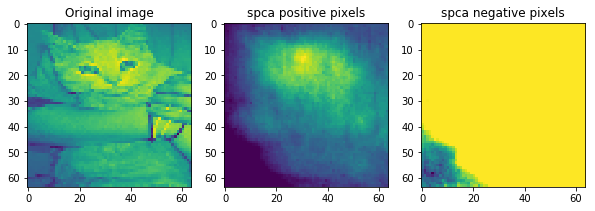

image index: 11445


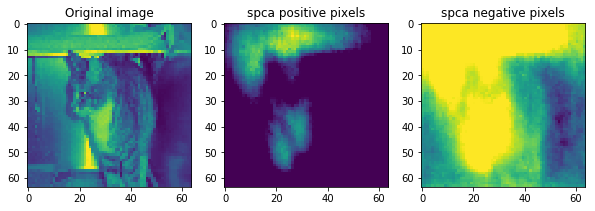

image index: 9939


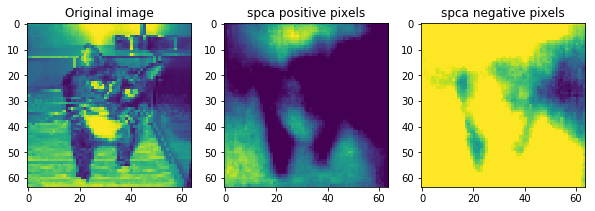

image index: 3610


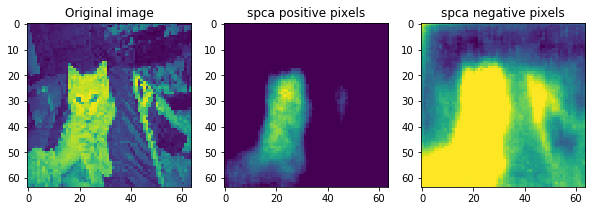

image index: 12245


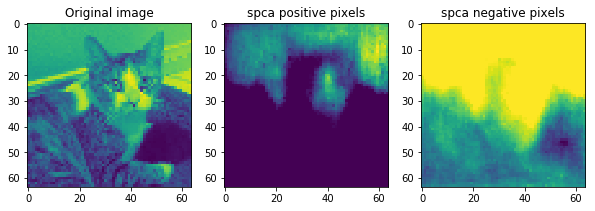

image index: 4399


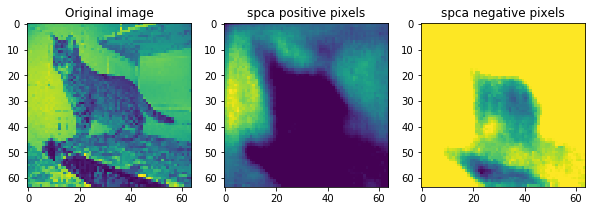

image index: 9159


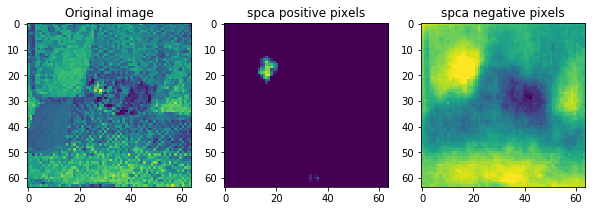

image index: 8810


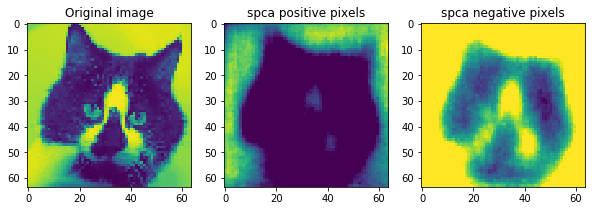

image index: 1272


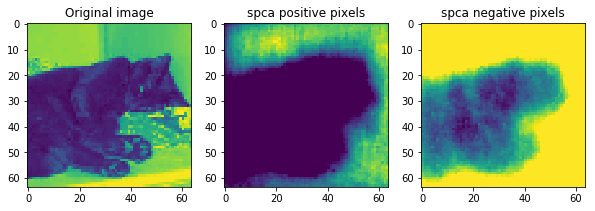

image index: 7718


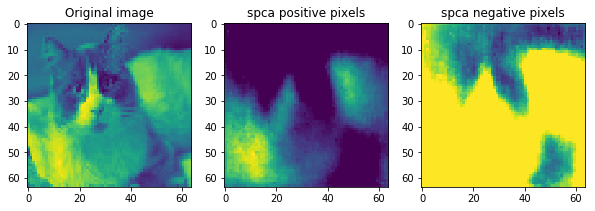

image index: 201


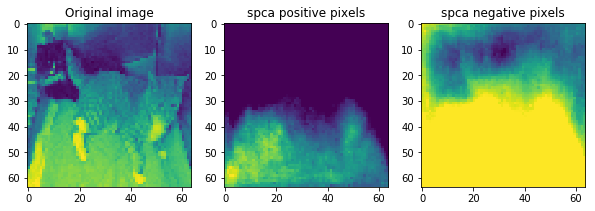

image index: 8169


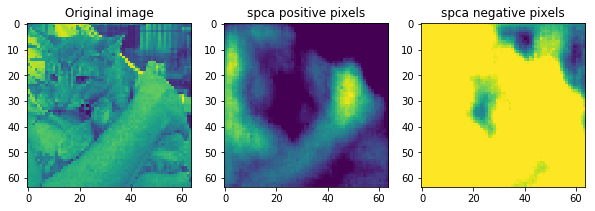

image index: 11712


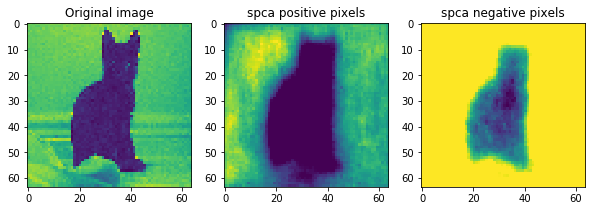

image index: 4108


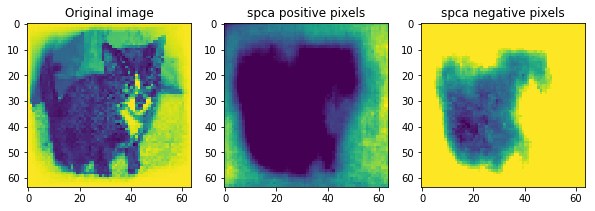

image index: 5909


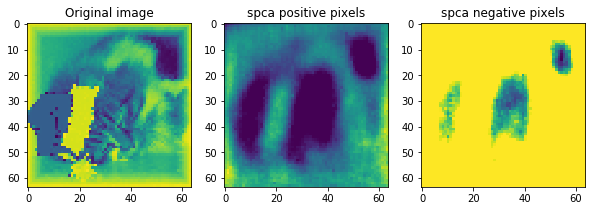

image index: 7140


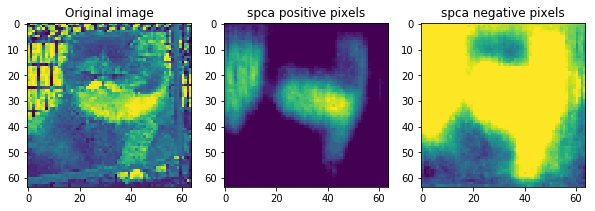

image index: 11319


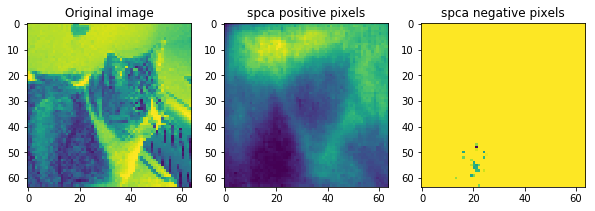

image index: 4603


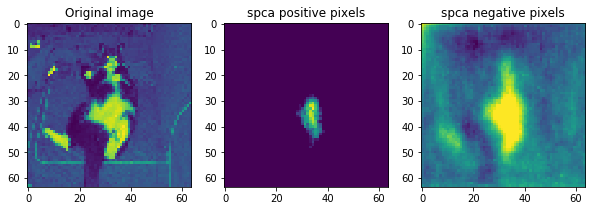

image index: 2721


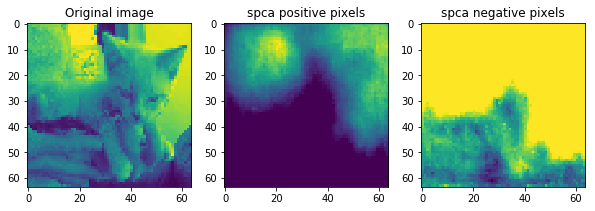

image index: 12350


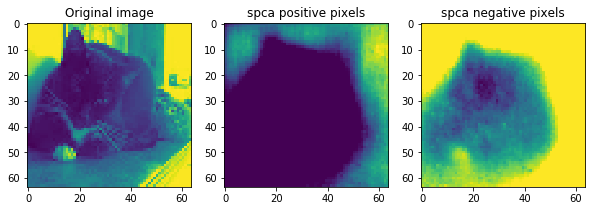

image index: 9726


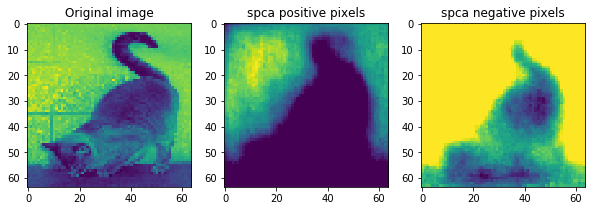

image index: 3145


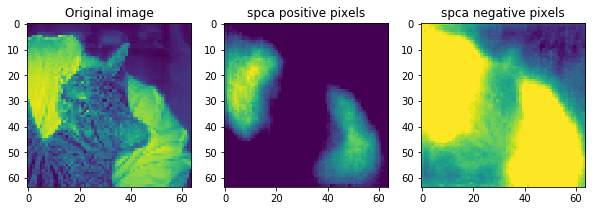

image index: 1412


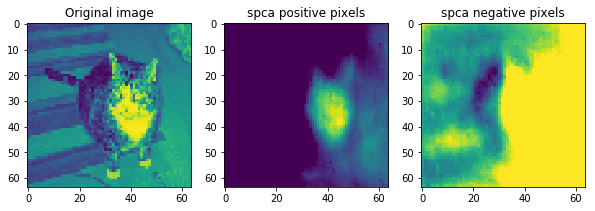

image index: 11077


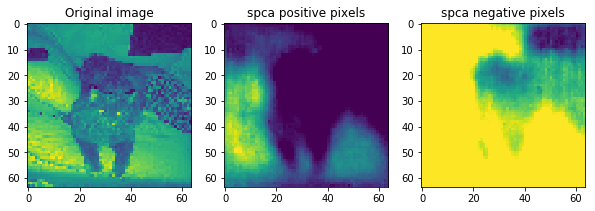

image index: 5458


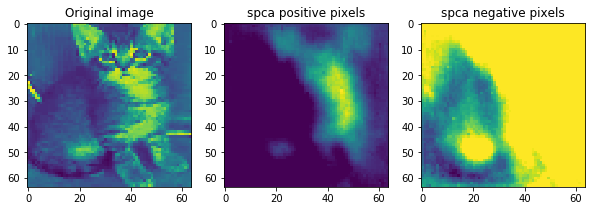

image index: 2067


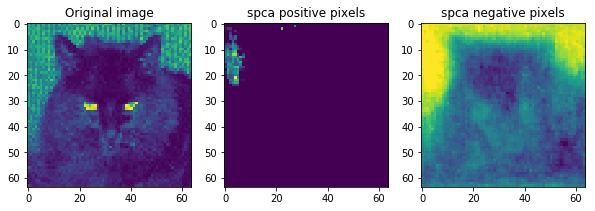

image index: 366


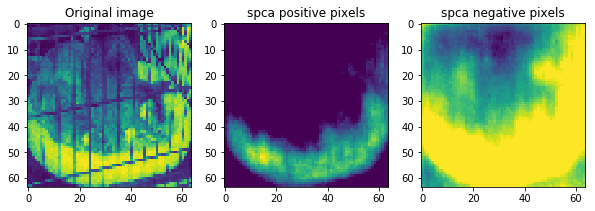

image index: 11348


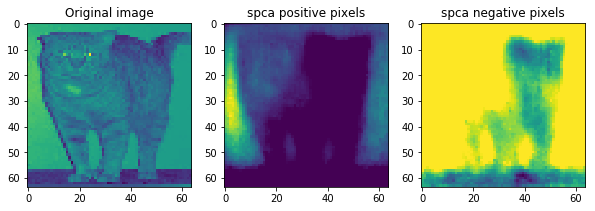

image index: 4307


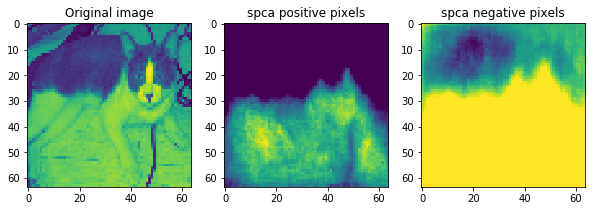

image index: 3107


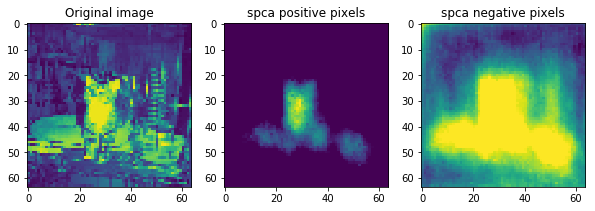

image index: 8375


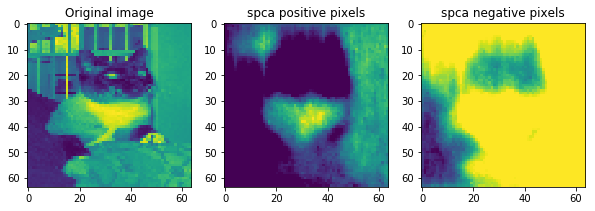

image index: 1073


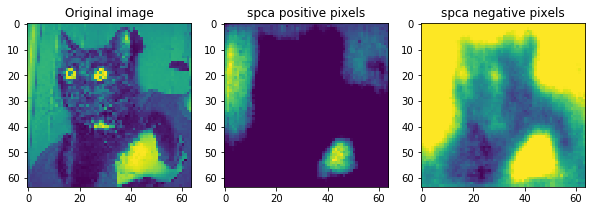

image index: 10501


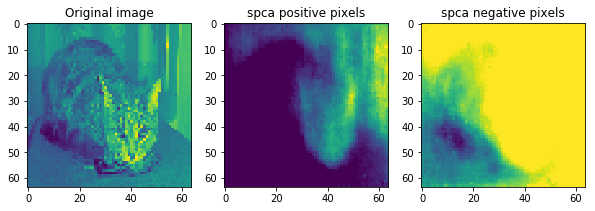

image index: 7344


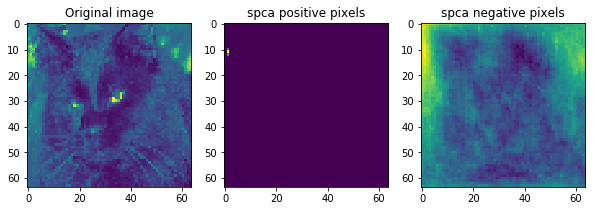

image index: 10805


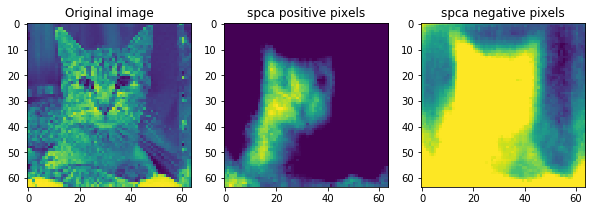

In [9]:
import random
plot_fig(random.sample(range(1, len(train_cats)), 35))